In [80]:
import quantecon as qe
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy import optimize

### Endogenous Grid Method

#### The Problem:

#### Standard VFI Form:

$$V_{n+1}(k_i , z_j) = \max_{k'} \left\{\dfrac{(z_jk_i^\alpha + (1-\delta)k_i - k')^{1-\gamma}}{1-\gamma} + \beta \mathbb{E}( V_n(k',z') | z_j)\right\}$$
$$\text{s.t. } k' \geq k_{min}$$
$$ln(z') = \rho ln(z) + \eta'$$

#### EGM Form:

$$V_{n+1}(k , z_j) = \max_{k_i'} \left\{\dfrac{(z_jk^\alpha + (1-\delta)k - k_i')^{1-\gamma}}{1-\gamma} + \beta \mathbb{E}( V_n(k_i',z') | z_j)\right\}$$
$$\text{s.t. } ln(z') = \rho ln(z) + \eta'$$

So in the EGM form, we are creating grid for:
- capital grid for tomorrow's values
- Today's states

To understand why this method is better than standard VFI, we need to look at the FOC that we have to solve in standard VFI and compare it the FOC of EGM:

- Standard VFI: $(z_jk_i^\alpha + (1-\delta)k_i - k')^{-\gamma} = \beta \mathbb{E}(V_k(k',z')|z_j)$

- EGM: $z_k k^\alpha + (1-\delta)k = [\beta \mathbb{E}(V_k(k_i',z')|z_j)]^{\frac{-1}{\gamma}}+ k_i'$ 

Yes, even in EGM we need to solve for k (and it is a non-linear equation) but it is much easier to solve the first one for k' because we don't need to interpolate $\mathbb{E}(V_k(k',z')|z_j)$ for each off grid k' because all the k' s are on the grid (we chose the tomorrow's capital grid). Another beautiful thing is that instead of constantly evaluating expected value for tomorrow as in Standard VFI FOC, in EGM, it is enough to compute it once.

Furthermore, we can even avoid solving this non-linear equation by carefully changing the state variable from the beginning of period to end of period total **cash on hand**

Define: $Y = z_jk^\alpha + (1-\delta)k$

Then Belmann equation becomes:

$$\hat V(Y,z_j) = \max_{k'} \left\{ \dfrac{(Y-k')^{1-\gamma}}{1-\gamma} + \underbrace{\beta \mathbb{E}(\hat V(Y',z')|z_j)}_{\mathbb{V}(k_i',z_j)}\right\}$$
$$\text{s.t. } Y' = z'k'^\alpha + (1-\delta)k'$$
$$ k' \geq k_{min}$$
$$ln(z') = \rho ln(z) + \eta'$$

More simply:

$$\hat V(Y,z_j) = \max_{k'} \left\{ \dfrac{(Y-k')^{1-\gamma}}{1-\gamma} + \mathbb{V}(k_i',z_j)\right\}$$
$$\text{s.t. } Y' = z'k'^\alpha + (1-\delta)k'$$
$$ k' \geq k_{min}$$
$$ln(z') = \rho ln(z) + \eta'$$

From FOC:

$$ c^*(k_i', z_j)^{-γ}  = \mathbb{V}_k(k_i', z_j)$$

From this equation, obtain $c^*$ and use it in the resource constraint to find $Y^*$:

$$Y^*(k_i',z_j) = c^*(k_i', z_j) + k_i'$$

Remember, this shows that in order to $k_i'$ to be selected tomorrow, you need to have this $Y^*(k_i',z_j)$ today at the end of the period. (we changed the timing)

And with this cash in hands today, we can find LHS of the value function as:

$$\hat V(Y^*(k_i',z_j),z_j) =\dfrac{(c^*(k_i',z_j))^{1-\gamma}}{1-\gamma} + \mathbb{V}(k_i',z_j) $$

Therefore, given tomorrow's capital grid and today's shock grid, we are able to find today's state variable $Y^*$ and by using interpolation, we are able to find the values $\hat V$ on the capital grid. Then, as in standarda VFI, we will update our value function with this newly founded value function and keep iterating the process until convergence. The algorithm is summarized below:

**Algorithm:**
- Step 0: Choose an initial guess $\mathbb{V}_0$ which has the dimension of $n_k$ x $n_z$ and create grids for $c^*,Y', Y^*, \text{Values}, \text{Interpolated 
Values}$ of the same dimension.

- Step 1: Create cash in hands matrix $Y' = Z K^\alpha + (1-δ)K$

- Step 2: Use the production function $zk^α$ as your initial guess. (instead of using zero value function, we need to have well behaved concave value function because if we use a constant value initial guess like zeros, then $\mathbb{V}_k$ is just zero and we are stuck.)

- Step 3: Given $\mathbb{V}_n$, get $c^*_{n}$ by using the FOC: $c^*(k_i',z_j) = \mathbb{V}_n'(k_i',z_j)^{\frac{-1}{γ}}$

- Step 4: After finding  $c^*$, get the today's end of period resources by $Y^*(k_i',z_j) = c^*(k_i', z_j) + k_i'$

- Bonus: To find k today, solve the non linear equation $Y^*[i,j] = z_j k^α + (1-δ)k$ for k.

- Step 5: Given $\mathbb{V}_n$ and computed get $c^*_{n}$, find the today's values by: $ \text{Values} =\dfrac{(c^*_n)^{1-\gamma}}{1-\gamma} + \mathbb{V}_n $

- Step 6: You have today's end of period cash in hand $Y^*_n$ from step 2 and corresponding values $Values$ from step 3. To get the values for on the grid $Y'$, do interpolation (do the interpolation for $Y'[k_i', z_j]$ by using the pair $(Y^*[:, z_j],Values[:,z_j])$, for each $k_i$, for each $z_j$) and get $Interpolated Values$ for $Y'$

- Step 7: Update your value function by: $\mathbb{V}_{n+1}(k'i, z_j) = β \mathbb{E}[\text{Interpolated Values}[k_i', :]|z_j] $

- Step 8: Iterate until convergence.




In [72]:
# Define Parameters:

n_k = 500  # Grids for capitals
n_A = 15  # Markov States.
δ = 0.9   # Depreciation.
α = 0.7   # Capital Share.
ρ = 0.98  # Memory of income
σ = 0.01  # Volatility of income.
β = 0.98  # Discont factor.
θ = 1.5   # Expanding grid coefficient.
error = 10e-6 # Error tolerance.
max_iter = 1000 # Maximum iteration

#Create aux variables for iteration
dist = 1000
iteration = 0

#Discretizing shocks
markov = qe.markov.approximation.rouwenhorst(n= n_A, ybar = 1-ρ, sigma=σ, rho= ρ)
Π = markov.P   
A = markov.state_values 

# Maximum sustainable Capital:
K_max = 2
K_min = 0.001

# Use and expanding grid for more accuracy:
Kp = K_min + (K_max - K_min) * (np.linspace(0, 1, n_k)**θ)

#Step 0: Some necessary matrices for computation
V_k = np.zeros((n_A,n_k))
c_star = np.zeros((n_A,n_k))
Y_star = np.zeros((n_A,n_k))
value = np.zeros((n_A,n_k))
Realvalue = np.zeros((n_A,n_k))

#Step 1: Creating on grid cash in hands matrix
Y_prime = np.zeros((n_A,n_k))
for i in range(n_A):
    for j in range(n_k):
        Y_prime[i,j] = A[i]* (Kp[j]** α)  + (1-δ)*Kp[j]

#Step 2: Initial guess
V_0 = np.zeros((n_A,n_k))
for i in range(n_A):
    for j in range(n_k):
        V_0[i,j] = Kp[j]**(α) * A[i]

In [73]:
delta = 10e-4
while dist > error and iteration < max_iter:
    for i in range(n_A):
        #Step 3: Doing the numerical derivative of the value matrix wrt k to get c_star
        V_spline = CubicSpline(Kp,V_0[i,:])
        c_star[i,:] = ((V_spline(Kp + delta) - V_spline(Kp - delta))/ (2*delta))**(-1/2)
    
    #Step 4: Finding Y_star
    Y_star = c_star + Kp
    
    #Step 5: Finding corresponding values
    Values = -c_star **(-1) + V_0
    

    for i in range(n_A):
        Y_i = Y_star[i,:]
        V_i = Values[i,:]

        #We need to sort Y_star to be able to interpolate
        sort_index = np.argsort(Y_i)
        Y_i_sorted = Y_i[sort_index]
        V_i_sorted = V_i[sort_index]

        #Step 6: Interpolate to get on grid values
        interpolation = CubicSpline(Y_i_sorted, V_i_sorted)
        Realvalue[i,:] = interpolation(Y_prime[i,:])

    #Step 7: Update your value
    V_1 = β * np.dot(Π, Realvalue)

    #Step 8: Check your
    dist = np.max(np.abs(V_1 - V_0))
    iteration += 1

    #Step 7: Update your value
    V_0 = V_1.copy()

    if iteration % 50 == 0:
        print('iteration: ', iteration)
        print('dist: ', dist)

iteration:  50
dist:  2.991585561326474
iteration:  100
dist:  0.9192595337162857
iteration:  150
dist:  0.31527997242960737
iteration:  200
dist:  0.11236158800937801
iteration:  250
dist:  0.040599274341275304
iteration:  300
dist:  0.014742950496156482
iteration:  350
dist:  0.0053633694094514794
iteration:  400
dist:  0.0019524390016840698
iteration:  450
dist:  0.0007109213091780475
iteration:  500
dist:  0.0002588830203080761
iteration:  550
dist:  9.427562747532647e-05
iteration:  600
dist:  3.433209735703713e-05
iteration:  650
dist:  1.2502679055614863e-05


In [74]:
V_1

array([[-994.07850316, -946.58067827, -883.26740371, ..., -385.60847301,
        -385.566574  , -385.52479147],
       [-943.47001983, -898.18176305, -837.85220392, ..., -366.55491312,
        -366.51588008, -366.47695588],
       [-897.03950302, -853.78511521, -796.20247005, ..., -349.025232  ,
        -348.9887879 , -348.95244573],
       ...,
       [-585.72907986, -556.42041439, -517.52914833, ..., -230.2783678 ,
        -230.25810578, -230.237902  ],
       [-564.8476    , -536.49144695, -498.88008454, ..., -222.23546226,
        -222.21619971, -222.19699269],
       [-545.21971287, -517.76161584, -481.35693108, ..., -214.66623727,
        -214.64790263, -214.62962095]])

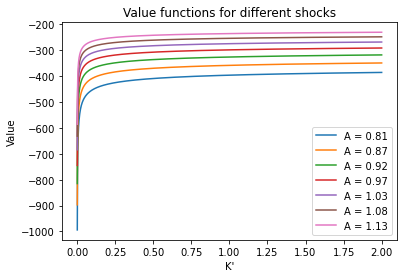

In [88]:
fig, ax = plt.subplots()
for i in range(n_A//2):
    ax.plot(Kp,V_1[2*i,:], label=f'A = {np.round(A[2*i],2)}')
ax.set_xlabel("K'")
ax.set_ylabel("Value")
ax.set_title(f'Value functions for different shocks')
ax.legend()
plt.show()
